<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-clustering-AQ-data/blob/main/DBSCAN_HDBSCAN_updated_April24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 4 March 2024

<font color='blue'> Authors:</font>
- Manar Anwer
- Amna Salim
- Shruti Govonda
- [Dr. Isam Al Jawarneh](https://isamaljawarneh.github.io/) (```supervisor```)


##Target
analyzing fine-grained (i.e., granular) environmental data. In this notebook :

*   time series graphs
*   basic maps with environmental data (low-cost Air Quality, AQ, sensors data)
*   Perform clustering analysis (e.g., DBSCAN) on pollution hotspots


##Part 0: Setup

Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.

In [ ]:
#Block 1
#here, we install the tool we are going to use to make some maps, called Folium

In [ ]:
!pip install folium

In [ ]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
from datetime import datetime
import os

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

## Part 1 -Time Series


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future!

In [ ]:
#Block 3

#below are the files for temp/humidity, PM and NO2 data.
#data from other deployments, including your own, may have only one file. If this is the case, use only one variable!

#th = "NYC_Pilot1.csv"
pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv"
#pm = "NYC_Pilot2_PM_Part1.csv"
#no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
#thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
#no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.

In [ ]:
pmdata.shape[0]

In [ ]:
#Block 4
tz = pytz.timezone('US/Eastern')
print("Data read")

In [ ]:
#Block 5

#here, we will show the first few lines of the data files. Check out what the start date and times are!
#thdata.head()

#uncomment the line below to see the start of the PM data file!
pmdata.head()

#uncomment the line below to see the start of the NO2 data file!
#no2data.head()

In [ ]:
#Block 6
#here, we will show the last few lines of the data files. Check out what the ending date and times are!
#thdata.tail()

#uncomment the line below to see the end of the PM data file!
pmdata.tail()

#uncomment the line below to see the end of the NO2 data file!
#no2data.tail()

Time to warm up with a map. Let's find some parameters from the deployment in time series - let's start with temperature and then try PM2.5!

Let's get some basic information about temperature from this deployment -
- The average temperature the devices saw
- The maximum temperatures the devices saw
- The minimum temperature the devices saw

In [ ]:
#Block 7
avg = pmdata['temperature'].mean()
max = pmdata['temperature'].max()
min = pmdata ['temperature'].min()
print("Temperature: ","\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
avg = pmdata['pm25'].mean()
max = pmdata['pm25'].max()
min = pmdata ['pm25'].min()
print("pm25: ", "\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
avg = pmdata['humidity'].mean()
max = pmdata['humidity'].max()
min = pmdata ['humidity'].min()
print("Humidity: ", "\nAvg value",avg, "\nMax value",max, "\nMin value",min)
print("################################################")
####################################################################
#th file variable names
#temperature, humidity

#pm file variable names
#pm25

#no2 file variable names
#no2

Now let's make a plot of the total temperature during the time we have collected the data for.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'time' column to datetime format
pmdata['time'] = pd.to_datetime(pmdata['time'], unit='s')

# Define variables to plot and their corresponding colors
variables = ['pm25', 'temperature', 'humidity']
colors = ['r', 'g', 'b']

# Create subplots with shared x-axis
fig, axes = plt.subplots(len(variables), 1, figsize=(25, 20), sharex=True)  # Adjust figsize for width

# Define font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 14}

# Iterate over variables and plot each one
for i, var in enumerate(variables):
    axes[i].plot(pmdata['time'], pmdata[var], '.', color=colors[i])
    axes[i].set_title(f'{var.capitalize()} Over Time', fontdict=font)
    axes[i].set_ylabel(var.capitalize(), fontdict=font)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=14)  # Set tick label font size

# Set common x-axis label
axes[-1].set_xlabel('Time', fontdict=font)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the interval of time
start_date = '2021-11-02 09:33'
end_date = '2021-12-01 09:42'

# Filter the DataFrame for the specified time range and make a copy
filtered_pmdata = pmdata[(pmdata['time'] >= start_date) & (pmdata['time'] <= end_date)].copy()

# Convert the 'time' column to datetime format
filtered_pmdata['time'] = pd.to_datetime(filtered_pmdata['time'], unit='s')

# Define variables to plot and their corresponding colors
variables = ['pm25', 'temperature', 'humidity']
colors = ['r', 'g', 'b']

# Create subplots with shared x-axis
fig, axes = plt.subplots(len(variables), 1, figsize=(25, 20), sharex=True)  # Adjust figsize for width

# Define font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 14}

# Iterate over variables and plot each one
for i, var in enumerate(variables):
    axes[i].plot(filtered_pmdata['time'], filtered_pmdata[var], 'o', color=colors[i])
    axes[i].set_title(f'{var.capitalize()} Over Time', fontdict=font)
    axes[i].set_ylabel(var.capitalize(), fontdict=font)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=14)  # Set tick label font size

# Set common x-axis label
axes[-1].set_xlabel('Time', fontdict=font)

plt.show()


Great - now replace the temperature parameters with humidity, and even pm2.5 or no2 from the other data files. Rerun the code and see what you get! What does the data tell you?

## Part 2 - Mapping + Hotspot Analysis

<font color='blue' size=12> supervisor comments </font>: April 2, 2024
- TODO:
  - ```Simple Random Sampling (SRS)``` such as the one that is done here might be not sufficient!
  - Perform ```stratified-like sampling``` instead, similar to the one we've done in the class, on a granular level could be based on geohash (take equal fractions from each geohash independently) or on a coarser level based on neighborhood, borough, or any other offical city administrative division (take equal fractions from each administrative division independently),
  - Thereafter, you do all the other steps that follow, normalization, scaling, clustering, visualization, etc., and you compare the results between SRS and stratified-like geospatial sampling!

  You need to draw several x-y figures to capture those comparisons, in the x-axis is the sampling fraction: 20%, 40%, 60%, 80%, 90%,,,, and in the y-axis probably the silhouette (for both SRS and stratified-like sampling schemes) using for example column graphs or line graphs. See example figure in the comments below

Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map!

In [ ]:
pmdata_sample=pmdata.sample(frac=0.1)

In [ ]:
pmdata_sample.shape[0]

In [ ]:
pmdata_sample.dtypes

In [ ]:
#Block 10
#we're going to make a map. we start by setting a center point for the map to display the data
coords = pmdata.loc[:,['latitude','longitude']].values #lat and lon are collected from CityScanner GPS
start_point=coords[0]

In [ ]:
pmdata_sample.iloc[5]['pm25']


In [ ]:
'''for i,row in pmdata_sample.iterrows():
  print(pmdata_sample.loc[i]["pm25"])'''

In [ ]:
#Block 11
#here, we set up the specifications for the map
newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=21)
colormap.caption = 'PM 2.5 (ug/m^3)' #change this to represent the variable of interest!
colormap.add_to(newmap)


#this will loop through the data and show us where it's coming from
#each point on the map will display the PM2.5 value from that spot, in micrograms per cubic meter.
for i,row in pmdata_sample.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['pm25']), fill ='true', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)

newmap.add_child(colormap)


#here we save an html version of the map - you can zoom in and out of it and interact with it!
#this .html file will be saved to your google drive folder. Download it to your computer and open it to interact with it!
#newmap.save('newmap.html')
#you may need to refresh the page on your google drive folder to see the updated map!
#you may also need to close a few tabs so you don't run out of memory when opening the map :)


#note - you can also create a map for a subset of the total deployment time by calling the "thdatamod", "pmdatamod", or "no2datamod" variable above!

In [ ]:
# Create a new map
newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')

# Create colormap for temperature
colormap = cm.LinearColormap(colors=['red', 'orange', 'yellow'], vmin=filtered_pmdata['temperature'].min(), vmax=filtered_pmdata['temperature'].max())
colormap.caption = 'Temperature (°C)'
colormap.add_to(newmap)

# Add circle markers for each data point


for i,row in pmdata_sample.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='red', fill_color='red', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['temperature']), fill ='true', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)

newmap.add_child(colormap)

# Save the map as HTML file
#newmap.save('temperature_map.html')

In [ ]:

# Create a new map
newmap = folium.Map(location=start_point, tiles='Stamen Terrain', zoom_start=14, attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL')

# Create colormap for temperature
colormap = cm.LinearColormap(colors=['blue', 'cyan', 'green'], vmin=filtered_pmdata['humidity'].min(), vmax=filtered_pmdata['humidity'].max())
colormap.caption = 'Humidity (%)'
colormap.add_to(newmap)

# Add circle markers for each data poi
for i,row in pmdata_sample.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.temperature)).add_to(newmap)
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['humidity']), fill ='true', fill_opacity=.5, popup=(row.humidity)).add_to(newmap)

newmap.add_child(colormap)

# Save the map as HTML file
#newmap.save('temperature_map.html')
# Save the map as HTML file

Now that we have our point map, showing us where pm2.5 values and potential hotspot locations are, let's do some clustering. This will allow us to see where multiple measurements exceed the threshold value, potentially indicating a local source of pollution or pollution transport.

In [ ]:
#Block 12
#let's start by setting 10 as the threshold value. Change this and see how the number of hotspots changes!
pmdata = pmdata.loc[(pmdata['pm25'] > 10)]

In [ ]:
pmdata.shape[0]

<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
  - You have based your distance calculation by applying the stock version of DBSCAN in sickit-learn as-is, relying on using ```haversine``` as a distance metric to calculate haversine distances between coordinates (longitudes/latitudes pairs)
  > the attention that should be given in this case is that you did not capture any statistics regarding the distribution of the pm25 values (our target variable), you could for example capture the histograms of those values.
  Read more about possible values of ```pm2.5``` in this reference [PM2.5 particles in the air](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air). This means that you need to create a histogram showing the density of each bracket, your binning strategy should rely on the community definition of ranges of values. For example, binning example is the follwoing: Less than 25, 25–50, 50–100, 100–300, More than 300. Simialr to what appears in the following figure:

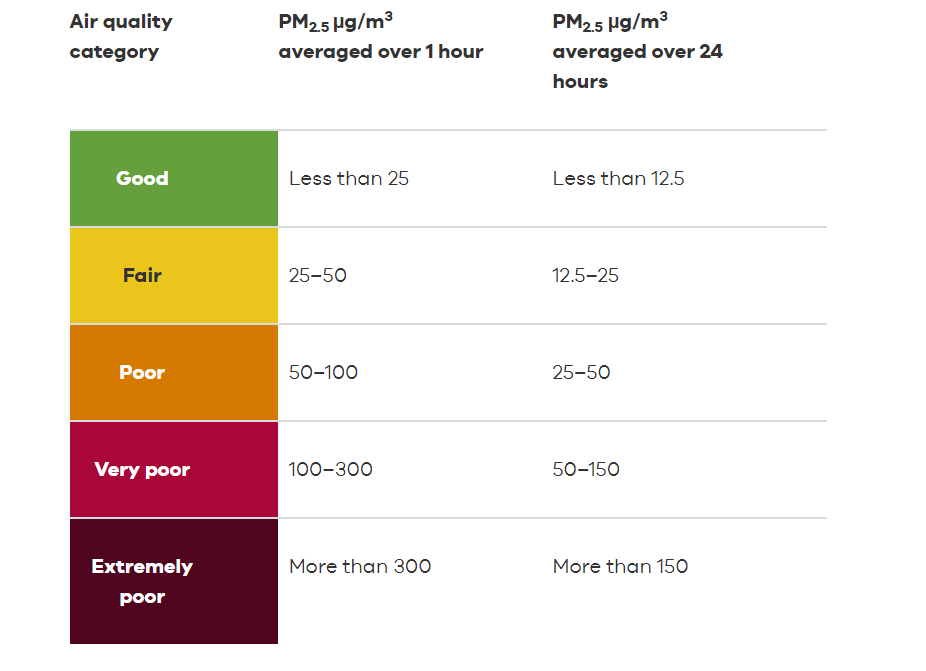

<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - Also, draw histograms showing the same binning and density of pm2.5 values in each neighborhood in your data. By the way, how many neighborhoods you have in your data?!
  > this is important as it will inform us about the fact wether nearby locations are having similar pm25 values. Why do we need to do this, because it is only in that case we consider those as a cluster, since they are geographiclly nearby, and also having simialr feature values (pm25 in this case). So what you need to do next is the following:
  - .. ```Extract and normalize several features```, similar to what has been done in the following tutorial, read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter ```Run DBSCAN to extract high-density clusters``` passing as an argument to the DBSCAN the new ```scaled features```, probably something like ```cores, labels = dbscan(features, eps=eps, min_samples=min_samples)``` . notice passing features (including pm25, longitude, latitude) instead of simply the coordinates.
  - having done this novel distance calculation (based on geometrical distance and pm25 values distance), calculate again the ```silhouette_score```, and check wether you obtain a higher accuracy (higher silhouette_score values) or not!

  > **N.B.** we are able to do this because of the definition of ```metric``` in DBSCAN which says **metric: The metric to use when calculating distance between instances in** a ```feature array``` so, it  a distance between several features is possible, given a ```feature array```, so put your scaled features in a feature array.

  - one importance configurable parameter in this case is the distance metric.
  > you can use instead
    - most importantly the following : ```From scikit-learn: [‘cityblock’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’].```
    - and probably aome of the following ```From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘rogerstanimoto’, ‘russellrao’,, ‘sokalmichener’, ‘sokalsneath’, ```

  - then, having permutate this configurable parameter, capture the ```silhouette_score``` and compare, then draw an x-y figure such as the following, (```you can do those graphs in MS excel after capturing the numbers```):

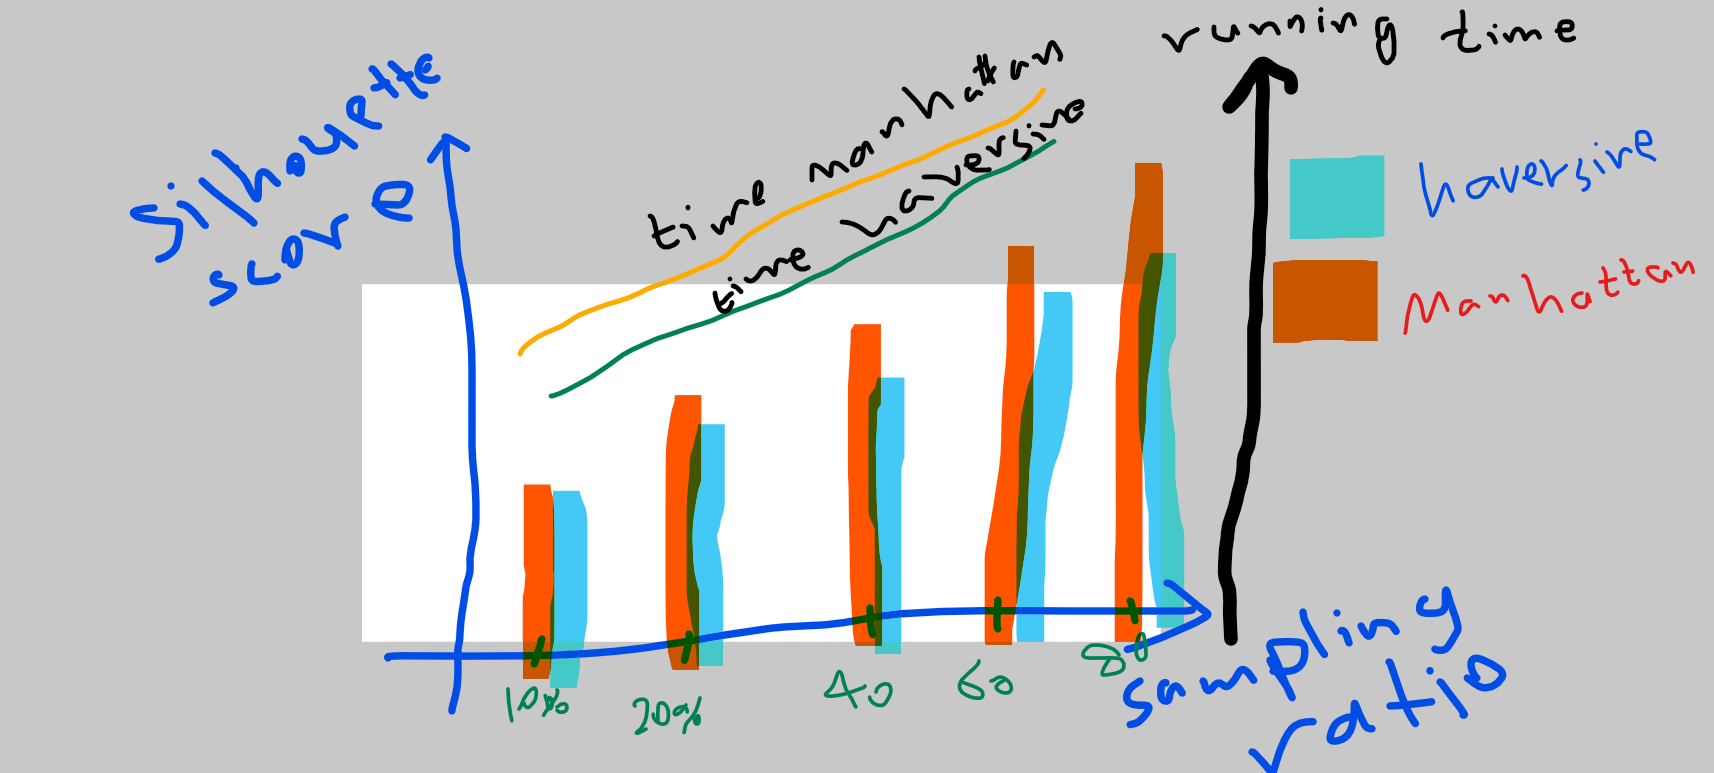

In [ ]:
#Block 13
#hierarchical clustering code

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
#outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

#here is where we create the clusters after doing the background math above
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
#outliers = coords[cluster_labels == -1]
#print('Number of clusters: {}'.format(num_clusters))
#print('Number of outliers: {}'.format(outliers))



<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
 - Provide a detailed explanation of the values you obtained for ```Silhouette Coefficient```
    - take some insights from [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - That is to say, >
    > "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN

print(f"Silhouette Coefficient: {metrics.silhouette_score(coords, cluster_labels):.3f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming 'pmdata' contains your data

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

# preprocessing for hotspot clustering
# we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

# epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

# min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) - (1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

# Plotting clusters
plt.figure(figsize=(10, 8))

# Generating colors for clusters
colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

for cluster_label, color in zip(range(num_clusters), colors):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_points = coords[cluster_mask]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=20, c=[color], label=f'Cluster {cluster_label}')

# Plotting outliers
plt.scatter(outliers[:, 1], outliers[:, 0], s=20, c='black', label='Outliers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Hotspots')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import folium
import numpy as np
import matplotlib.colors as mcolors

import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming you already have 'cluster_labels' and 'coords' from your code

# Calculate the center of the map
center_lat = np.mean(coords[:, 0])
center_lon = np.mean(coords[:, 1])

# Create the map
map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Custom color palette for clusters
colors = plt.cm.tab20.colors[:32]

# Convert colors to hexadecimal format
custom_colors = [mcolors.rgb2hex(color) for color in colors]
# You can add more colors as needed

# Assign colors to clusters
cluster_color_map = {}
for label in set(cluster_labels):
    if label == -1:
        cluster_color_map[label] = 'gray'  # Noise points
    else:
        cluster_color_map[label] = custom_colors[label % len(custom_colors)]

# Plot each data point
for point, cluster_label in zip(coords, cluster_labels):
    folium.CircleMarker(
        location=[point[0], point[1]],
        radius=5,
        color=cluster_color_map[cluster_label],
        fill=True,
        fill_color=cluster_color_map[cluster_label],
        fill_opacity=0.7,
        markeredgecolor="k",
        markersize=6,
    ).add_to(map_clusters)

# Display the map
map_clusters.save("cluster_map.html")  # Save as HTML
map_clusters


<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - you need to do more analytics and Exploratory Spatio-Temporal Data Analytics (ESTDA,  read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter, for example ```Identify the 5 largest clusters``` , ```Get mean statistics for the top 5 largest clusters```, ```Visualize the top 5 largest clusters```, ```Visualizing one cluster at a time```.

## Implementation for the HDBSCAN

In [ ]:
# compare with HDBSCAN
!pip install hdbscan
import hdbscan

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.cluster import DBSCAN, HDBSCAN

# Assuming 'pmdata' contains your data

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

# preprocessing for hotspot clustering
# we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

# epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

# Use HDBSCAN for clustering
clusterer = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=10, metric='haversine')
cluster_labels = clusterer.fit_predict(np.radians(coords))
num_clusters = len(set(cluster_labels)) - (1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

# Plotting clusters
plt.figure(figsize=(8, 8))



# Generating colors for clusters
colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

for cluster_label, color in zip(range(num_clusters), colors):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_points = coords[cluster_mask]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=20, c=[color], label=f'Cluster {cluster_label}')

# Plotting outliers
plt.scatter(outliers[:, 1], outliers[:, 0], s=20, c='black', label='Outliers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Hotspots for HDBSCAN')
#plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import folium
import numpy as np
import matplotlib.colors as mcolors

import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming you already have 'cluster_labels' and 'coords' from your code

# Calculate the center of the map
center_lat = np.mean(coords[:, 0])
center_lon = np.mean(coords[:, 1])

# Create the map
map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Custom color palette for clusters
#colors = plt.cm.tab20.colors[:32]

# Generating colors for clusters
colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

# Convert colors to hexadecimal format
custom_colors = [mcolors.rgb2hex(color) for color in colors]
# You can add more colors as needed

# Assign colors to clusters
cluster_color_map = {}
for label in set(cluster_labels):
    if label == -1:
        cluster_color_map[label] = 'gray'  # Noise points
    else:
        cluster_color_map[label] = custom_colors[label % len(custom_colors)]

# Plot each data point
for point, cluster_label in zip(coords, cluster_labels):
    folium.CircleMarker(
        location=[point[0], point[1]],
        radius=5,
        color=cluster_color_map[cluster_label],
        fill=True,
        fill_color=cluster_color_map[cluster_label],
        fill_opacity=0.7,
        markeredgecolor="k",
        markersize=6,
    ).add_to(map_clusters)

# Display the map
map_clusters.save("cluster_map.html")  # Save as HTML
map_clusters


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
#from sklearn.cluster import DBSCAN

print(f"Silhouette Coefficient: {metrics.silhouette_score(coords, cluster_labels):.3f}")

In [ ]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_hdb = calinski_harabasz_score(coords, cluster_labels)
print("HDBSCAN Calinski-Harabasz Index:", calinski_harabasz_hdb)

<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO
  - add other metrics from the [sklearn.metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), for example the following:
  > - ```Davies-Bouldin Index```, **Zero is the lowest possible score. Values closer to zero indicate a better partition.**
  for your experiment, we have obtained a number on par with 2.78!, which is very high! so probably your clustering scheme misses something! try different combinations of configurations (sampling scheme, distance methods, distance based on combination of features such as geographical long/lat and pm25 values), read my previous comments to get insights.
    - ```Calinski-Harabasz Index```. You have computed that already, but what is your explanation and reasoning of the results obtained!

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(np.radians(coords), cluster_labels)

##Resources and references


Papers:
*   [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
*  [ City Scanner: Building and Scheduling a Mobile
Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
* [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)



Python Library Documentation:
*  [Folium](http://python-visualization.github.io/folium/)
*  [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)


